In [1]:
import cv2
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
from timeit import default_timer as timer
import itertools

from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from scikitplot.metrics import plot_roc, auc
import scikitplot as skplt

from sklearn.externals import joblib

**Data Augmentation: resize + flip + blur + denoise**

In [26]:
root_imagenes = 'imagenes/motos'
root_imagenes_mnist = 'imagenes/motos_mnist/'

In [22]:
## Aplica algoritmos de Data Augmentation a cada imagen y las guardar en una nueva carpeta.
def preprocesar_imagen(ruta_imagen):
    for path, subdirs, files in os.walk(ruta_imagen):
        name = ""
        for name in files:
            try:
                img_path = os.path.join(path,name)
                img = cv2.imread(img_path)
                img = resize_image(root_imagenes_mnist + name,img)
                flip_image(root_imagenes_mnist + "_flip_" + name,img)
                blur_image(root_imagenes_mnist + "_blur_" + name,img)
                denoise_image(root_imagenes_mnist + "_denoise_" + name,img)
                
            except Exception as e:
                print(e)
                print(name)

In [27]:
preprocesar_imagen(root_imagenes)

In [10]:
## Lleva una imagen a Formato MNIST 28x28.
def resize_image(path,img):
    resize_img=cv2.resize(img, (28,28))
    cv2.imwrite(path,resize_img)  
    return resize_img
    

In [5]:
## Voltea una imagen
def flip_image(path,img):
    flip_img=cv2.flip(img,1)
    cv2.imwrite(path,flip_img)  

In [6]:
## Desenfoca una imagen
def blur_image(path, img):
    blur_img = cv2.blur(img,(20,20))
    cv2.imwrite(path,blur_img)  

In [7]:
## Elimina ruido en una imagen
def denoise_image(path, img):
    denoise_img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) # Leer: https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html
    cv2.imwrite(path,denoise_img)  

**Procesamiento de Pixeles +  Almacenamiento de Imágenes en un CSV**

In [33]:
rutas_images_mnist = [
    'imagenes/autos_mnist/',
    'imagenes/buggy_mnist/',
    'imagenes/camiones_mnist/',
    'imagenes/camionetas_mnist/',
    'imagenes/colectivos_mnist/',
    'imagenes/cuatriciclos_mnist/',
    'imagenes/furgones_mnist/',
    'imagenes/motos_mnist/',
    'imagenes/palacargadora_mnist/'
]

In [8]:
labels = ['Auto', 'Buggy', 'Camioneta', 'Camion', 'Colectivo',
         'Cuatriciclo', 'Furgon', 'Moto', 'Pala Cargadora']

In [35]:
def crear_dataframe():
    arreglo = []
    df = pd.DataFrame()
    for ruta_imagen in rutas_images_mnist:
        print(ruta_imagen)
        for path, subdirs, files in os.walk(ruta_imagen):
            name = ""
            
            numero_categoria = get_numero_categoria(ruta_imagen)
            
            for name in files:
                try:
                    # Abro la imagen
                    img_path = os.path.join(path,name)
                    img = cv2.imread(img_path)
                    
                    # Paso a Escala de Grises --> este me deja una sola dimension de RGB.
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
                    
                    # Normalización de Pixeles: divido cada píxel por 255.
                    img = img / 255 

                    # Aplano una imagen: obtenemos una array de una dimensión con los pixeles de la imagen.
                    array_img = img.ravel() 
                    
                    # Agrego al final del array anterior un entero que representa la categoría de vehículo.
                    array_img = np.insert(array_img,len(array_img), numero_categoria)
                    
                    arreglo.append(array_img) 
                    
                except Exception as e:
                    print(e)
                    #print(name)


        df = pd.DataFrame(arreglo)
        #print(df)
    return df

In [36]:
# Dada el nombre de categoria devuelve su posición en arreglo de labels.
def get_numero_categoria(categoria):
    if("auto" in categoria):
        return 0
    elif("buggy" in categoria):
        return 1
    elif("camioneta" in categoria):
        return 2
    elif("camion" in categoria):
        return 3
    elif("colectivo" in categoria):
        return 4
    elif("cuatriciclo" in categoria):
        return 5
    elif("furgon" in categoria):
        return 6
    elif("moto" in categoria):
        return 7
    elif("pala" in categoria):
        return 8
    else:
        return -1

In [37]:
df = crear_dataframe()

imagenes/autos_mnist/
imagenes/buggy_mnist/
imagenes/camiones_mnist/
imagenes/camionetas_mnist/
imagenes/colectivos_mnist/
imagenes/cuatriciclos_mnist/
imagenes/furgones_mnist/
imagenes/motos_mnist/
imagenes/palacargadora_mnist/


In [38]:
print(df)

           0         1         2         3         4         5         6    \
0     0.721569  0.733333  0.686275  0.670588  0.686275  0.631373  0.670588   
1     0.650980  0.627451  0.647059  0.643137  0.650980  0.650980  0.733333   
2     0.294118  0.674510  0.631373  0.603922  0.580392  0.521569  0.564706   
3     0.462745  0.596078  0.545098  0.505882  0.498039  0.466667  0.529412   
4     0.392157  0.388235  0.364706  0.352941  0.254902  0.282353  0.337255   
5     0.125490  0.105882  0.105882  0.125490  0.074510  0.129412  0.309804   
6     0.333333  0.909804  0.890196  0.964706  0.925490  0.698039  0.682353   
7     0.976471  0.972549  0.972549  0.968627  0.972549  0.976471  0.984314   
8     0.254902  0.262745  0.254902  0.466667  0.156863  0.274510  0.411765   
9     0.082353  0.058824  0.309804  0.372549  0.592157  0.556863  0.690196   
10    0.639216  0.541176  0.572549  0.654902  0.450980  0.576471  0.556863   
11    0.752941  0.780392  0.874510  0.882353  0.854902  0.847059

In [39]:
# Guardamos el dataframe
df.to_csv('data_frame_imagenes', sep=',')

 **Dividimos nuestro dataset: Datos de Entrenamiento (80%) y Datos de Prueba (20%)**

In [2]:
# Abrimos el dataframe con las imagenes procesadas
df = pd.read_csv('data_frame_imagenes', sep=',')

In [41]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,0,0.721569,0.733333,0.686275,0.670588,0.686275,0.631373,0.670588,0.682353,0.725490,...,0.439216,0.407843,0.415686,0.427451,0.431373,0.419608,0.415686,0.419608,0.490196,0.0
1,1,0.650980,0.627451,0.647059,0.643137,0.650980,0.650980,0.733333,0.682353,0.674510,...,0.274510,0.341176,0.352941,0.427451,0.501961,0.529412,0.545098,0.545098,0.568627,0.0
2,2,0.294118,0.674510,0.631373,0.603922,0.580392,0.521569,0.564706,0.568627,0.694118,...,0.047059,0.054902,0.058824,0.082353,0.121569,0.145098,0.160784,0.192157,0.207843,0.0
3,3,0.462745,0.596078,0.545098,0.505882,0.498039,0.466667,0.529412,0.529412,0.505882,...,0.078431,0.074510,0.078431,0.078431,0.113725,0.435294,0.474510,0.717647,0.729412,0.0
4,4,0.392157,0.388235,0.364706,0.352941,0.254902,0.282353,0.337255,0.870588,0.956863,...,0.050980,0.047059,0.043137,0.054902,0.105882,0.094118,0.086275,0.070588,0.086275,0.0
5,5,0.125490,0.105882,0.105882,0.125490,0.074510,0.129412,0.309804,0.090196,0.058824,...,0.094118,0.101961,0.117647,0.149020,0.188235,0.172549,0.243137,0.266667,0.317647,0.0
6,6,0.333333,0.909804,0.890196,0.964706,0.925490,0.698039,0.682353,0.968627,0.984314,...,0.396078,0.298039,0.380392,0.360784,0.372549,0.321569,0.376471,0.403922,0.368627,0.0
7,7,0.976471,0.972549,0.972549,0.968627,0.972549,0.976471,0.984314,0.960784,0.964706,...,0.109804,0.125490,0.149020,0.145098,0.164706,0.149020,0.168627,0.160784,0.137255,0.0
8,8,0.254902,0.262745,0.254902,0.466667,0.156863,0.274510,0.411765,0.462745,0.635294,...,0.082353,0.094118,0.105882,0.109804,0.125490,0.133333,0.239216,0.133333,0.172549,0.0
9,9,0.082353,0.058824,0.309804,0.372549,0.592157,0.556863,0.690196,0.764706,0.690196,...,0.121569,0.105882,0.109804,0.105882,0.109804,0.101961,0.094118,0.086275,0.086275,0.0


In [68]:
# Para tensorflow.
df.to_csv('data_frame_imagenes_tensorflow', sep='/')

In [3]:
## Divido datos de entrenamiento y datos de prueba ###
df_datos = df
#X = df_datos[df_datos.columns[:-1]].values
X = df_datos[df_datos.columns[1:-1]].values # Desde la columna 1 hasta la columna anteultima.
y = df_datos[df_datos.columns[len(df_datos.columns)-1]].values # Solamente la ultima columna

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42, 
)

In [5]:
# Verifico que el maximo valor en X_test sea 1...
np.amax(X_test)

1.0

In [45]:
## ¿Están balanceados los datos? ##
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[805 789 809 821 797 793 791 796 799]


In [46]:
# Genera una serie de barras en el gráfico de barras.
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5

    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))
    
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('Categoría de Vehículos')
    plt.ylabel(ylabel_text)

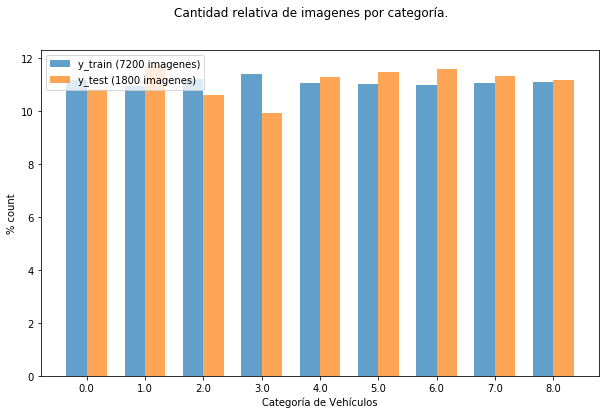

In [47]:
### Grafico que compara y_train con y_test ###
plt.figure(figsize=(10,6)) 
plt.suptitle('Cantidad relativa de imagenes por categoría.')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
legend1 = plt.legend([
    'y_train ({0} imagenes)'.format(len(y_train)),
    'y_test ({0} imagenes)'.format(len(y_test))
])
#legend2 = plt.legend([
 #   '1 = auto',
  #  '8 = moto'
#],loc=1)
#plt.gca().add_artist(legend1)
#plt.gca().add_artist(legend2)

**Preprocesamiento: PCA con 2 Componentes**

In [54]:
comienzo = timer()
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X_train)
fin = timer() - comienzo

In [55]:
print("Tiempo que tardó en entrenar y transformar:",fin, " segundos")

Tiempo que tardó en entrenar y transformar: 0.5288380165475246  segundos


In [56]:
print(pca.explained_variance_ratio_)

[0.28900906 0.0856452 ]


In [76]:
plt.rcParams["figure.figsize"] = [15, 8]

In [23]:
class_names = np.unique(y_test)
class_names

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [59]:
labels = ['Auto', 'Buggy', 'Camion', 'Camioneta', 'Colectivo', 'Cuatriciclo', 'Furgon', 'Moto', 'Pala Cargadora']

In [60]:
colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']

In [61]:
for k, i in enumerate(class_names):
    print(k,i)

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0
7 7.0
8 8.0


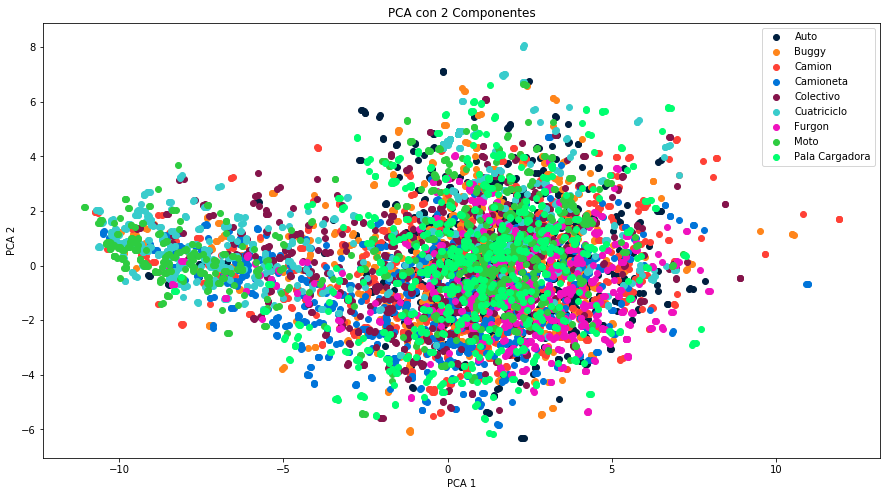

In [77]:
comienzo = timer()

for k, i in enumerate(class_names):
    plt.scatter(X_reduced[y_train == i, 0],
               X_reduced[y_train == i, 1],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])

plt.title("PCA con 2 Componentes")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

fin = timer() - comienzo

In [78]:
print("Tiempo que tardó en graficar:",fin, " segundos")

Tiempo que tardó en graficar: 0.6780363081925316  segundos


**Preprocesamiento: PCA con 3 Componentes**

In [80]:
# Instanciamos PCA y lo entrenamos.
comienzo = timer()

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_train)

fin = timer() - comienzo

In [81]:
print("Tiempo que tardó en entrenar y transformar:",fin, " segundos")

Tiempo que tardó en entrenar y transformar: 0.6431932365376269  segundos


In [82]:
# Obtenemos la variabilidad de cada componente.
print(pca.explained_variance_ratio_)

[0.28900906 0.0856452  0.05252211]


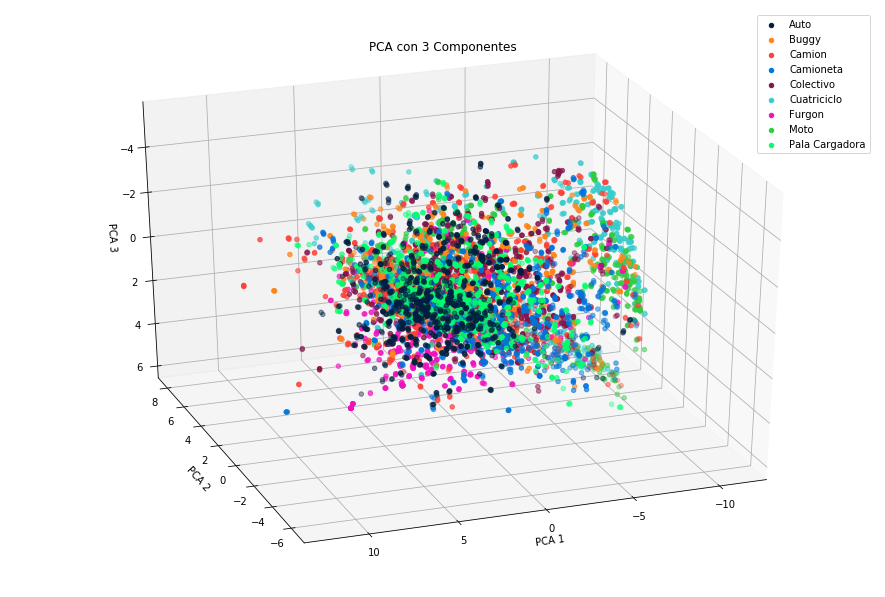

In [84]:
# Graficamos
comienzo = timer()

# Configuramos plt
fig = plt.figure(1, figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)

for k, i in enumerate(class_names):
    ax.scatter(X_reduced[y_train == i, 0],
               X_reduced[y_train == i, 1],
               X_reduced[y_train == i, 2],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])
    


ax.set_title("PCA con 3 Componentes")
ax.set_xlabel("PCA 1")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PCA 2")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PCA 3")
#ax.w_zaxis.set_ticklabels([])

plt.legend()
plt.show()

fin = timer() - comienzo

In [85]:
print("Tiempo que tardó graficar:",fin, " segundos")

Tiempo que tardó graficar: 1.9206229036935838  segundos


FALTA EXPLICAR LA VARIABILIDAD DE LOS DATOS EN PCA CON 2 COMPONENTES Y 3 COMPONENTES.

**Preprocesamiento: T-SNE con 2 Componentes**

In [86]:
# Instanciamos y entrenamos T-SNE.
comienzo = timer()

transformada2 = TSNE(n_components=2).fit_transform(X_train)
print(transformada2.shape)

fin = timer() - comienzo

(7200, 2)


In [87]:
print("Tiempo que tardó en entrenar y transformar:",fin, " segundos")

Tiempo que tardó en entrenar y transformar: 333.94238109074286  segundos


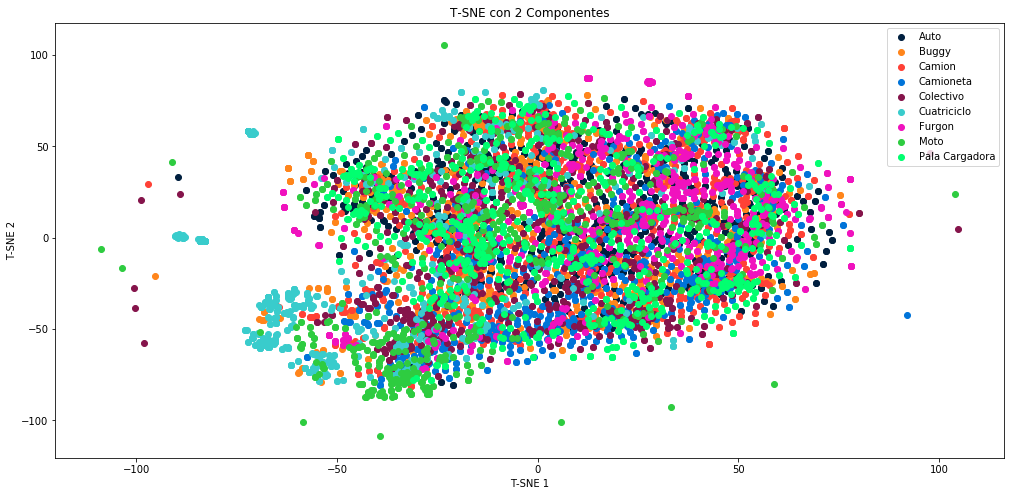

In [91]:
# Graficamos.
comienzo = timer()

plt.rcParams["figure.figsize"] = [17, 8]

for k, i in enumerate(class_names):
    plt.scatter(transformada2[y_train == i, 0],
               transformada2[y_train == i, 1],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])

plt.title("T-SNE con 2 Componentes")
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend()
plt.show()

fin = timer() - comienzo

In [92]:
print("Tiempo que tardó en graficar:",fin, " segundos")

Tiempo que tardó en graficar: 1.0270428471085324  segundos


**Preprocesamiento: T-SNE con 3 Componentes**

In [93]:
# Instanciamos y entrenamos T-SNE.
comienzo = timer()

transformada3 = TSNE(n_components=3).fit_transform(X_train)
print(transformada3.shape)

fin = timer() - comienzo

(7200, 3)


In [94]:
print("Tiempo que tardó en entrenar y transformar:",fin, " segundos")

Tiempo que tardó en entrenar y transformar: 915.0810629546977  segundos


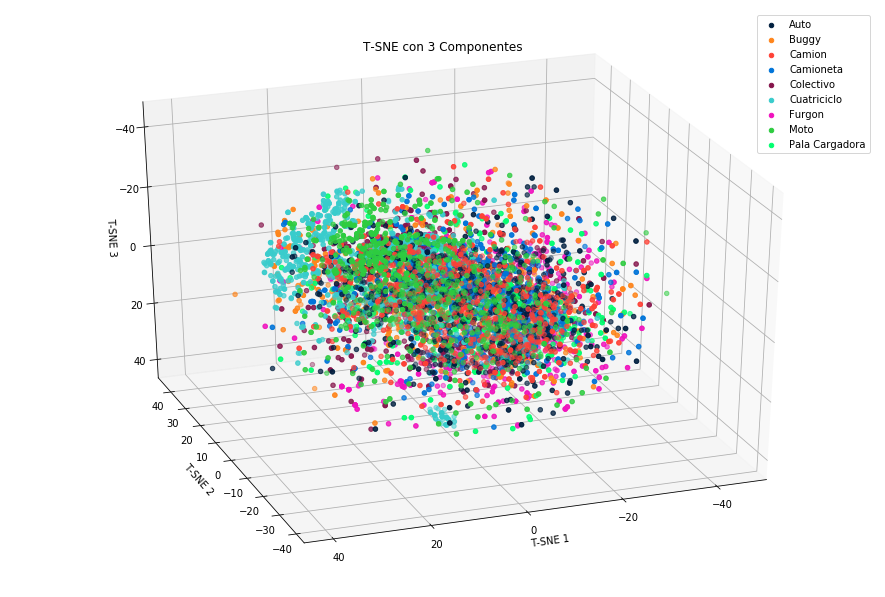

In [95]:
# Graficamos en 3D.
comienzo = timer()

fig = plt.figure(1, figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)

for k, i in enumerate(class_names):
    ax.scatter(transformada3[y_train == i, 0],
               transformada3[y_train == i, 1],
               transformada3[y_train == i, 2],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])
    


ax.set_title("T-SNE con 3 Componentes")
ax.set_xlabel("T-SNE 1")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("T-SNE 2")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("T-SNE 3")
#ax.w_zaxis.set_ticklabels([])

plt.legend()
plt.show()

fin = timer() - comienzo

In [96]:
print("Tiempo que tardó en graficar:",fin, " segundos")

Tiempo que tardó en graficar: 2.075264532726578  segundos


In [97]:
transformada3.std

<function ndarray.std>

**Hiper Parametrización**

Hiper Parametrización: para cada modelo svm, dummy, kneighbords, etc., debo aplicar gridserachsv,
se trata de un metodo que agarra cada modelo y le va cambiando los parametros automaticamente, 
y asi nos dice que parametros son los mejores para ese modelo.
Por ejemplo, nosotros usamos svm polinomico de grado 2, pero capaz que el mejor modelo es un svm polinomico de grado 5,
o uno lineal....
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

NOTA: Si alcanzamos con el tiempo, implementaremos esta funcionalidad.

In [20]:
CLASSES = {
    0: "Auto",
    1: "Buggy",
    2: "Camion",
    3: "Camioneta",
    4: "Colectivo",
    5: "Cuatriciclo",
    6: "Furgon",
    7: "Moto",
    8: "Pala Cargadora"
}

In [21]:
classes = [x for x in CLASSES.values()]

**Modelo 1: Dummy Classiffier**

In [60]:
### Entrenamos la maquina Dummy ###
comienzo = timer()

clf = DummyClassifier(strategy='prior', random_state=0)
clf.fit(X_train, y_train)

fin = timer() - comienzo

print("Tiempo Entrenamiento Dummy:",fin, " segundos")

#Persistimos el modelo entrenado con joblib.
joblib.dump(clf, 'dummy.joblib') 

Tiempo Entrenamiento Dummy: 0.001295512181968661  segundos


['dummy.joblib']

In [61]:
### Evaluación de la máquina Dummy ###
comienzo = timer()

dummy_predict = clf.predict(X_test)

fin = timer() - comienzo

print("Tiempo Test Dummy:",fin, " segundos")

Tiempo Test Dummy: 0.00021439069314510562  segundos


In [62]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, dummy_predict, target_names=classes)
print(tabla_f1_score)

                precision    recall  f1-score   support

          Auto       0.00      0.00      0.00       195
         Buggy       0.00      0.00      0.00       211
        Camion       0.00      0.00      0.00       191
     Camioneta       0.10      1.00      0.18       179
     Colectivo       0.00      0.00      0.00       203
   Cuatriciclo       0.00      0.00      0.00       207
        Furgon       0.00      0.00      0.00       209
          Moto       0.00      0.00      0.00       204
Pala Cargadora       0.00      0.00      0.00       201

     micro avg       0.10      0.10      0.10      1800
     macro avg       0.01      0.11      0.02      1800
  weighted avg       0.01      0.10      0.02      1800



c:\users\asus\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
# Metrica: Exactitud (Acurrancy)
print(accuracy_score(y_test, dummy_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, dummy_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.09944444444444445
179


<Figure size 432x432 with 0 Axes>

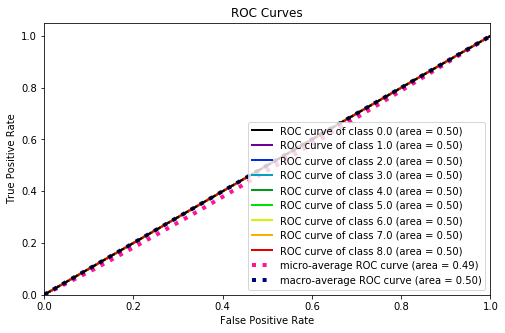

In [64]:
# Metrica: Curva ROC y Métrica AUC
fig = plt.figure(1, figsize=(6, 6))
#fig.clear()

plot_roc(y_test,clf.predict_proba(X_test))

plt.show()

Confusion matrix, without normalization


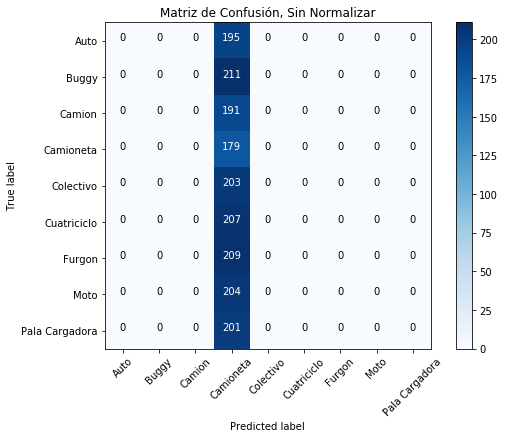

In [112]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, dummy_predict)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Matriz de Confusión, Sin Normalizar')

Normalized confusion matrix


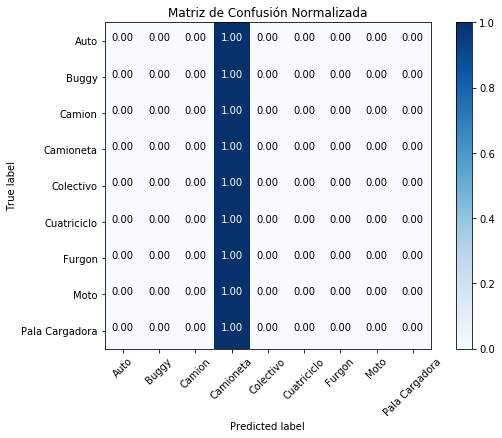

In [118]:
fig.clear()
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Matriz de Confusión Normalizada')

In [9]:
# Método que permite graficar una matriz de confusión.
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.rcParams["figure.figsize"] = [8, 5]
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [117]:
print(labels)

['Auto', 'Buggy', 'Camion', 'Camioneta', 'Colectivo', 'Cuatriciclo', 'Furgon', 'Moto', 'Pala Cargadora']


**Modelo 2: SVM (Support Vector Machines)**

Acá utilizamos un Kernel polinómico de grado 2.

In [10]:
### Entrenamos la maquina SVM ###
comienzo = timer()

svc = svm.SVC(kernel='poly', degree=2, C=1.0, probability=True, gamma='scale' )
svc.fit(X_train, y_train)  

fin = timer() - comienzo
print("Tiempo Entrenamiento SVM:",fin, " segundos")

#Persistimos el modelo entrenado con joblib.
joblib.dump(svc, 'svm2.joblib')

Tiempo Entrenamiento SVM: 657.6696821234834  segundos


['svm2.joblib']

In [11]:
### Evaluación de la máquina SVM ###
comienzo = timer()

y_predict = svc.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test SVM:",fin, " segundos")

Tiempo Test SVM: 21.90623157579978  segundos


In [12]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict, target_names=classes)
print(tabla_f1_score)

                precision    recall  f1-score   support

          Auto       0.24      0.56      0.34       195
         Buggy       0.42      0.23      0.30       211
        Camion       0.39      0.25      0.30       191
     Camioneta       0.42      0.45      0.43       179
     Colectivo       0.72      0.45      0.56       203
   Cuatriciclo       0.72      0.53      0.61       207
        Furgon       0.62      0.48      0.54       209
          Moto       0.59      0.41      0.49       204
Pala Cargadora       0.26      0.43      0.33       201

     micro avg       0.42      0.42      0.42      1800
     macro avg       0.49      0.42      0.43      1800
  weighted avg       0.49      0.42      0.43      1800



In [13]:
# Metrica: Exactitud (Acurrancy)
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.4216666666666667
759


<Figure size 1008x720 with 0 Axes>

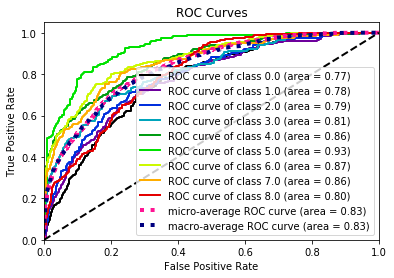

In [18]:
# Metrica: curva ROC y Métrica AUC
fig = plt.figure(1, figsize=(14, 10))
fig.clear()
plot_roc(y_test, svc.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


<Figure size 720x432 with 0 Axes>

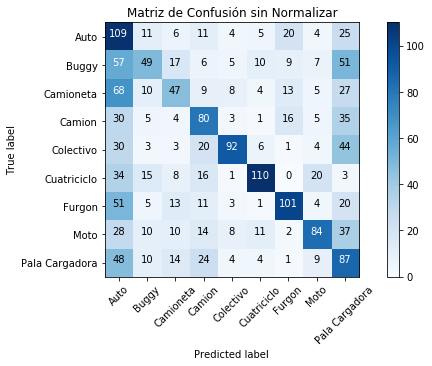

In [26]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Matriz de Confusión sin Normalizar')

Normalized confusion matrix


<Figure size 720x576 with 0 Axes>

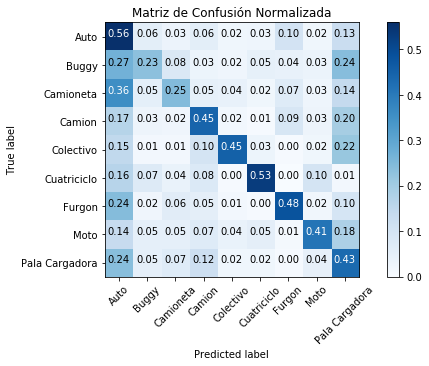

In [30]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10,8))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Matriz de Confusión Normalizada')

Acá utilizamos un Kernel polinómico de grado 3.

In [31]:
### Entrenamos la maquina SVM ###
comienzo = timer()

svc = svm.SVC(kernel='poly', degree=3, C=1.0, probability=True, gamma='scale' )
svc.fit(X_train, y_train)  

fin = timer() - comienzo
print("Tiempo Entrenamiento SVM:",fin, " segundos")

#Persistimos el modelo entrenado con joblib.
joblib.dump(svc, 'svm3.joblib')

Tiempo Entrenamiento SVM: 616.0693257694793  segundos


['svm3.joblib']

In [32]:
### Evaluación de la máquina SVM ###
comienzo = timer()

y_predict = svc.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test SVM:",fin, " segundos")

Tiempo Test SVM: 11.273170062596364  segundos


In [33]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict, target_names=classes)
print(tabla_f1_score)

                precision    recall  f1-score   support

          Auto       0.24      0.67      0.36       195
         Buggy       0.43      0.24      0.31       211
        Camion       0.41      0.24      0.30       191
     Camioneta       0.49      0.44      0.47       179
     Colectivo       0.77      0.43      0.55       203
   Cuatriciclo       0.77      0.56      0.64       207
        Furgon       0.72      0.50      0.59       209
          Moto       0.64      0.46      0.54       204
Pala Cargadora       0.30      0.47      0.36       201

     micro avg       0.44      0.44      0.44      1800
     macro avg       0.53      0.44      0.46      1800
  weighted avg       0.53      0.44      0.46      1800



In [34]:
# Metrica: Exactitud (Acurrancy)
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.4444444444444444
800


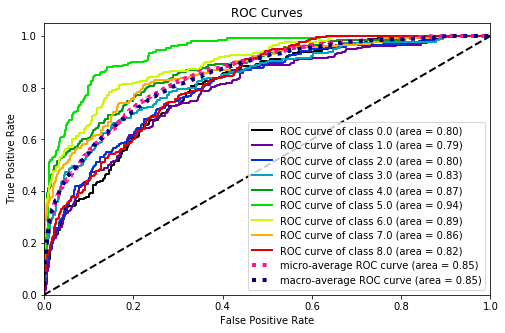

In [35]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
#fig = plt.figure(1, figsize=(14, 10))
plot_roc(y_test, svc.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


<Figure size 576x432 with 0 Axes>

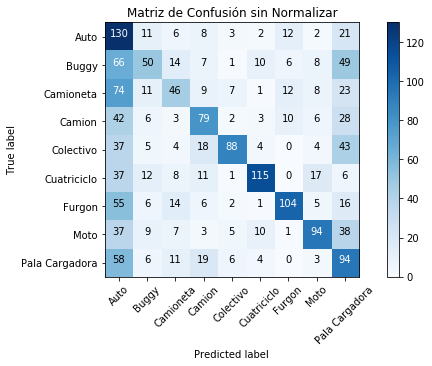

In [36]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Matriz de Confusión sin Normalizar')

Normalized confusion matrix


<Figure size 576x432 with 0 Axes>

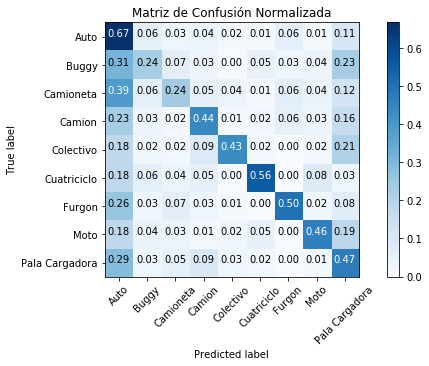

In [37]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Matriz de Confusión Normalizada')

**Modelo 3: KNeighborsClassifier**

In [39]:
### KNeighborsClassifier ###
### Entrenamiento ####
comienzo = timer()

kneigh = KNeighborsClassifier(n_neighbors=6, weights='uniform')
kneigh.fit(X_train, y_train) 

fin = timer() - comienzo
print("Tiempo Entrenamiento KNeighborsClassifier:",fin, " segundos")

#Persistimos el modelo entrenado con joblib.
joblib.dump(kneigh, 'kneigh.joblib')

Tiempo Entrenamiento KNeighborsClassifier: 0.30979067287626094  segundos


['kneigh.joblib']

In [40]:
### Evaluación de la máquina KNeighbors ###
comienzo = timer()

y_predict = kneigh.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test SVM:",fin, " segundos")

Tiempo Test SVM: 17.4159503854803  segundos


In [41]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict, target_names=classes)
print(tabla_f1_score)

                precision    recall  f1-score   support

          Auto       0.35      0.52      0.42       195
         Buggy       0.34      0.36      0.35       211
        Camion       0.33      0.42      0.37       191
     Camioneta       0.49      0.42      0.46       179
     Colectivo       0.38      0.39      0.39       203
   Cuatriciclo       0.64      0.79      0.71       207
        Furgon       0.61      0.49      0.54       209
          Moto       0.55      0.37      0.44       204
Pala Cargadora       0.43      0.24      0.31       201

     micro avg       0.45      0.45      0.45      1800
     macro avg       0.46      0.45      0.44      1800
  weighted avg       0.46      0.45      0.44      1800



In [42]:
# Metrica: Exactitud (Acurrancy)
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.4477777777777778
806


<Figure size 1008x720 with 0 Axes>

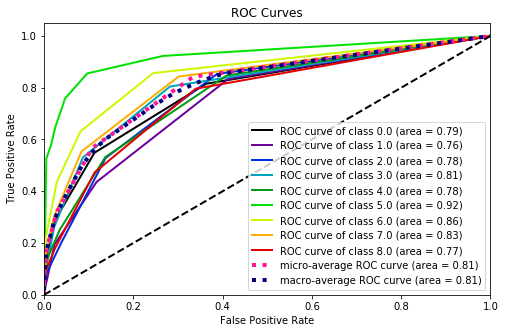

In [43]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
fig = plt.figure(1, figsize=(14, 10))
plot_roc(y_test, kneigh.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


<Figure size 576x432 with 0 Axes>

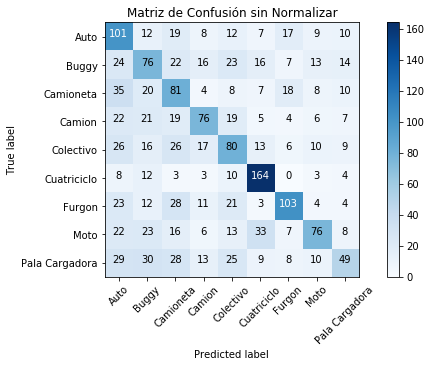

In [44]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Matriz de Confusión sin Normalizar')

Normalized confusion matrix


<Figure size 576x432 with 0 Axes>

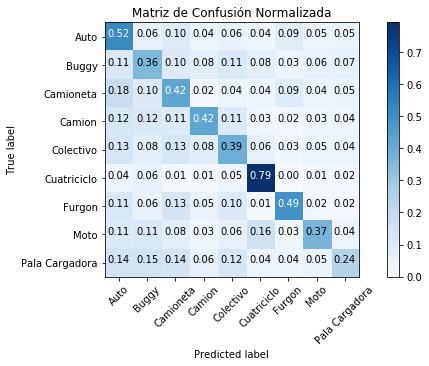

In [45]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Matriz de Confusión Normalizada')

**Modelo 4: RandomForestClassifier**

In [46]:
### Entrenamos la maquina RandomForest ###
comienzo = timer()

rf = RandomForestClassifier() # Creando el modelo
rf.fit(X_train, y_train) # Ajustando el modelo

fin = timer() - comienzo
print("Tiempo Entrenamiento RandomForestClassifier:",fin, " segundos")

#Persistimos el modelo entrenado con joblib.
joblib.dump(rf, 'randomforest.joblib')

c:\users\asus\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Tiempo Entrenamiento RandomForestClassifier: 1.4676597986417619  segundos


['randomforest.joblib']

In [47]:
### Evaluamos RandomForest ###
comienzo = timer()

y_predict = rf.predict(X_test)

fin = timer() - comienzo
print("Tiempo Test RandomForestClassifier:",fin, " segundos")

Tiempo Test RandomForestClassifier: 0.020983489095669938  segundos


In [48]:
### Metricas: F1 Score
tabla_f1_score = classification_report(y_test, y_predict, target_names=classes)
print(tabla_f1_score)

                precision    recall  f1-score   support

          Auto       0.40      0.61      0.48       195
         Buggy       0.49      0.45      0.47       211
        Camion       0.51      0.55      0.53       191
     Camioneta       0.56      0.60      0.58       179
     Colectivo       0.65      0.57      0.60       203
   Cuatriciclo       0.79      0.82      0.80       207
        Furgon       0.72      0.68      0.70       209
          Moto       0.73      0.58      0.64       204
Pala Cargadora       0.67      0.53      0.59       201

     micro avg       0.60      0.60      0.60      1800
     macro avg       0.61      0.60      0.60      1800
  weighted avg       0.62      0.60      0.60      1800



In [51]:
# Metrica: Exactitud (Acurrancy)
print(accuracy_score(y_test, y_predict, normalize=True, sample_weight=None)) # return the fraction of correctly classified samples (float)
print(accuracy_score(y_test, y_predict, normalize=False, sample_weight=None)) # Retorna cant de instancias clasificadas correctamente (int).

0.5983333333333334
1077


<Figure size 1008x720 with 0 Axes>

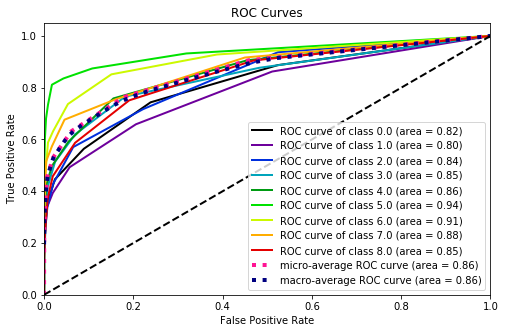

In [52]:
# Metrica: curva ROC y Métrica AUC
fig.clear()
fig = plt.figure(1, figsize=(14, 10))
plot_roc(y_test, rf.predict_proba(X_test))
plt.show()

Confusion matrix, without normalization


<Figure size 1080x432 with 0 Axes>

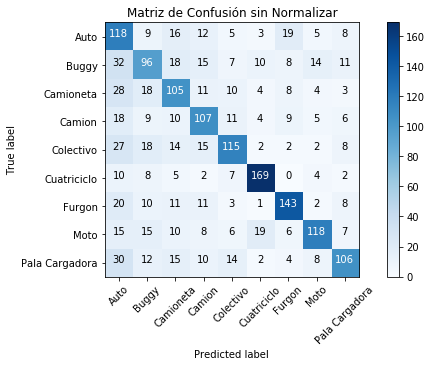

In [55]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(15,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False ,title='Matriz de Confusión sin Normalizar')

Normalized confusion matrix


<Figure size 576x432 with 0 Axes>

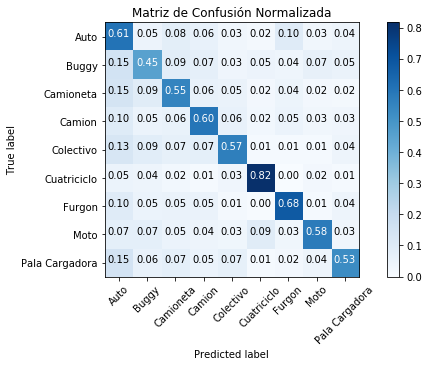

In [56]:
### Metrica: Matriz de Confusión
fig.clear()
cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True ,title='Matriz de Confusión Normalizada')

**Persistencia de los modelos entrenados: sklearn joblib**

https://scikit-learn.org/stable/modules/model_persistence.html

In [ ]:
#Para guardar un modelo entrando
from sklearn.externals import joblib
joblib.dump(modelo, 'filename.joblib') 

In [ ]:
#Para levantar un modelo entrando
from sklearn.externals import joblib
modelo = joblib.load('filename.joblib') 

**Probando la Predicción de los Modelos**

In [58]:
### Predecir categoria ####
img = cv2.imread('imagenes/camioneta.jpg')
resize_img=cv2.resize(img, (28,28))
resize_img = cv2.cvtColor(resize_img,cv2.COLOR_BGR2GRAY) 
                    
# Normalización de píxeles, divido cada píxel por 255
resize_img = resize_img / 255 
array_img = resize_img.ravel()

Xnew = []
Xnew.append(array_img)

### Vemos a que clase pertenece ###
print(clf.predict(Xnew)) # dummy
print(svc.predict(Xnew)) # svm
print(kneigh.predict(Xnew)) # K-neighbors
print(rf.predict(Xnew)) # RandomForest

[2.]
[7.]
[0.]


In [ ]:
def obtenerNombreCategoria(numero_categoria[0]):
    if numero_categoria == 0:
        return "un Auto"
    elif numero_categoria == 1:
        return "un Buggy"
    elif numero_categoria == 2:
        return "un Camion"
    elif numero_categoria == 3:
        return "una Camioneta"
    elif numero_categoria == 4:
        return "un Colectivo"
    elif numero_categoria == 5:
        return "un Cuatriciclo"
    elif numero_categoria == 6:
        return "un Furgon"
    elif numero_categoria == 7:
        return "una Moto"
    elif numero_categoria == 8:
        return "una Pala Cargadora"   

In [ ]:
FALTA HACER LA APP WEB...............

In [ ]:
FALTA COMPLETAR EL INFORME..............